#### This notebook looks into the estimated variances for the connectivity weights

In [1]:
import init_paths
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import Functional_Fusion.dataset as fdata
import Functional_Fusion.atlas_map as at
import glob
import matplotlib.pyplot as plt
from cortico_cereb_connectivity.scripts.script_train_eval_models import *
import cortico_cereb_connectivity.evaluation as ev
import matplotlib.pyplot as plt
from scipy import stats
import SUITPy as suit

Matplotlib created a temporary cache directory at /tmp/matplotlib-jfalnbb2 because the default path (/localscratch/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def plot_cereb_data(data,cereb_atlas,cscale=[-0.1,0.1]):
    # Transform the data to a nifti image
    nifti_img = cereb_atlas.data_to_nifti(data)
    # Map to the cerebellar flatmap 
    flat_data = suit.flatmap.vol_to_surf(nifti_img)
    # Plot 
    suit.flatmap.plot(flat_data,new_figure=False,cscale=cscale)

In [3]:
var_folder = os.path.join(os.getcwd(), '../data/variance')

dataset = fdata.get_dataset_class(gl.base_dir,
                                    dataset="MDTB")
subject_list = dataset.get_participants().participant_id

# read subject weight variance matrix from file
sigma2_mat = []
sigma2_subt = []
sigma2_reli = []
variance_list = []
params_list = []
for s, sub in enumerate(subject_list):
    print(f'Reading {str(sub)} sigma2_eps...')
    file_path = os.path.join(var_folder, f'sigma2_eps_{str(sub)}.npy')
    sigma2_mat.append(np.load(file_path))
    file_path = os.path.join(var_folder, f'sigma2_eps2_{str(sub)}.npy')
    sigma2_subt.append(np.load(file_path))
    file_path = os.path.join(var_folder, f'sigma2_eps3_{str(sub)}.npy')
    sigma2_reli.append(np.load(file_path))
    
    # plt.hist(variance, bins='auto', alpha=0.5)
    # shape, loc, scale = stats.gamma.fit(variance[~np.isnan(variance)], floc=0)
    # params_list.append((shape, loc, scale))
    # print(f'max: {np.nanmax(variance)}')

# # show
# plt.title('Histogram of sigma2_eps')
# plt.xlim((0,0.1))
# plt.show()

Reading sub-02 sigma2_eps...
Reading sub-03 sigma2_eps...
Reading sub-04 sigma2_eps...
Reading sub-06 sigma2_eps...
Reading sub-08 sigma2_eps...
Reading sub-09 sigma2_eps...
Reading sub-10 sigma2_eps...
Reading sub-12 sigma2_eps...
Reading sub-14 sigma2_eps...
Reading sub-15 sigma2_eps...
Reading sub-17 sigma2_eps...
Reading sub-18 sigma2_eps...
Reading sub-19 sigma2_eps...
Reading sub-20 sigma2_eps...
Reading sub-21 sigma2_eps...
Reading sub-22 sigma2_eps...
Reading sub-24 sigma2_eps...
Reading sub-25 sigma2_eps...
Reading sub-26 sigma2_eps...
Reading sub-27 sigma2_eps...
Reading sub-28 sigma2_eps...
Reading sub-29 sigma2_eps...
Reading sub-30 sigma2_eps...
Reading sub-31 sigma2_eps...


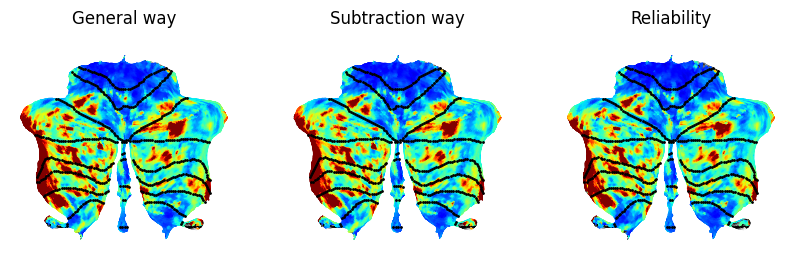

In [6]:
cereb_atlas,_ = at.get_atlas('SUIT3')
subj_i = [1]
for i in subj_i:
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plot_cereb_data(sigma2_mat[i],cereb_atlas,cscale=[0,1])
    plt.title(f'General way')
    plt.subplot(1,3,2)
    plot_cereb_data(sigma2_subt[i],cereb_atlas,cscale=[0,1])
    plt.title(f'Subtraction way')
    plt.subplot(1,3,3)
    plot_cereb_data(sigma2_reli[i],cereb_atlas,cscale=[0,1])
    plt.title(f'Reliability')

In [7]:
R1_list = []
R2_list = []
R3_list = []
for i in range(len(subject_list)):
    R1, _ = ev.calculate_R(sigma2_mat[i], sigma2_subt[i])
    R2, _ = ev.calculate_R(sigma2_subt[i], sigma2_reli[i])
    R3, _ = ev.calculate_R(sigma2_mat[i], sigma2_reli[i])
    R1_list.append(R1)
    R2_list.append(R2)
    R3_list.append(R3)
print(f'Average correlation between General way and Subtraction way: {np.nanmean(R1_list)}')
print(f'Average correlation between Subtraction way and Reliability way: {np.nanmean(R2_list)}')
print(f'Average correlation between General way and Reliability way: {np.nanmean(R3_list)}')

Average correlation between General way and Subtraction way: 1.0
Average correlation between Subtraction way and Reliability way: 0.8353423004771652
Average correlation between General way and Reliability way: 0.8353423004771653


In [13]:
df2=rm.comb_eval(models=['MDs1-ind-scale','MDs1-loo-scale','MDs1-avg-scale'],eval_data=['MDTBs2'])
df2['model_type'] = df2['model']
df2.loc[df2['model'].isna() & (df2.subj_id != df2.eval_subj),'model_type']='diff'
df2.loc[df2['model'].isna() & (df2.subj_id == df2.eval_subj),'model_type']='same'
df_same = df2[df2['model_type']=='same']
df_same.reset_index(drop=True, inplace=True)
df_avg = df2[df2['model_type']=='avg']
df_avg.reset_index(drop=True, inplace=True)
df_loo = df2[df2['model_type']=='loo']
df_loo.reset_index(drop=True, inplace=True)

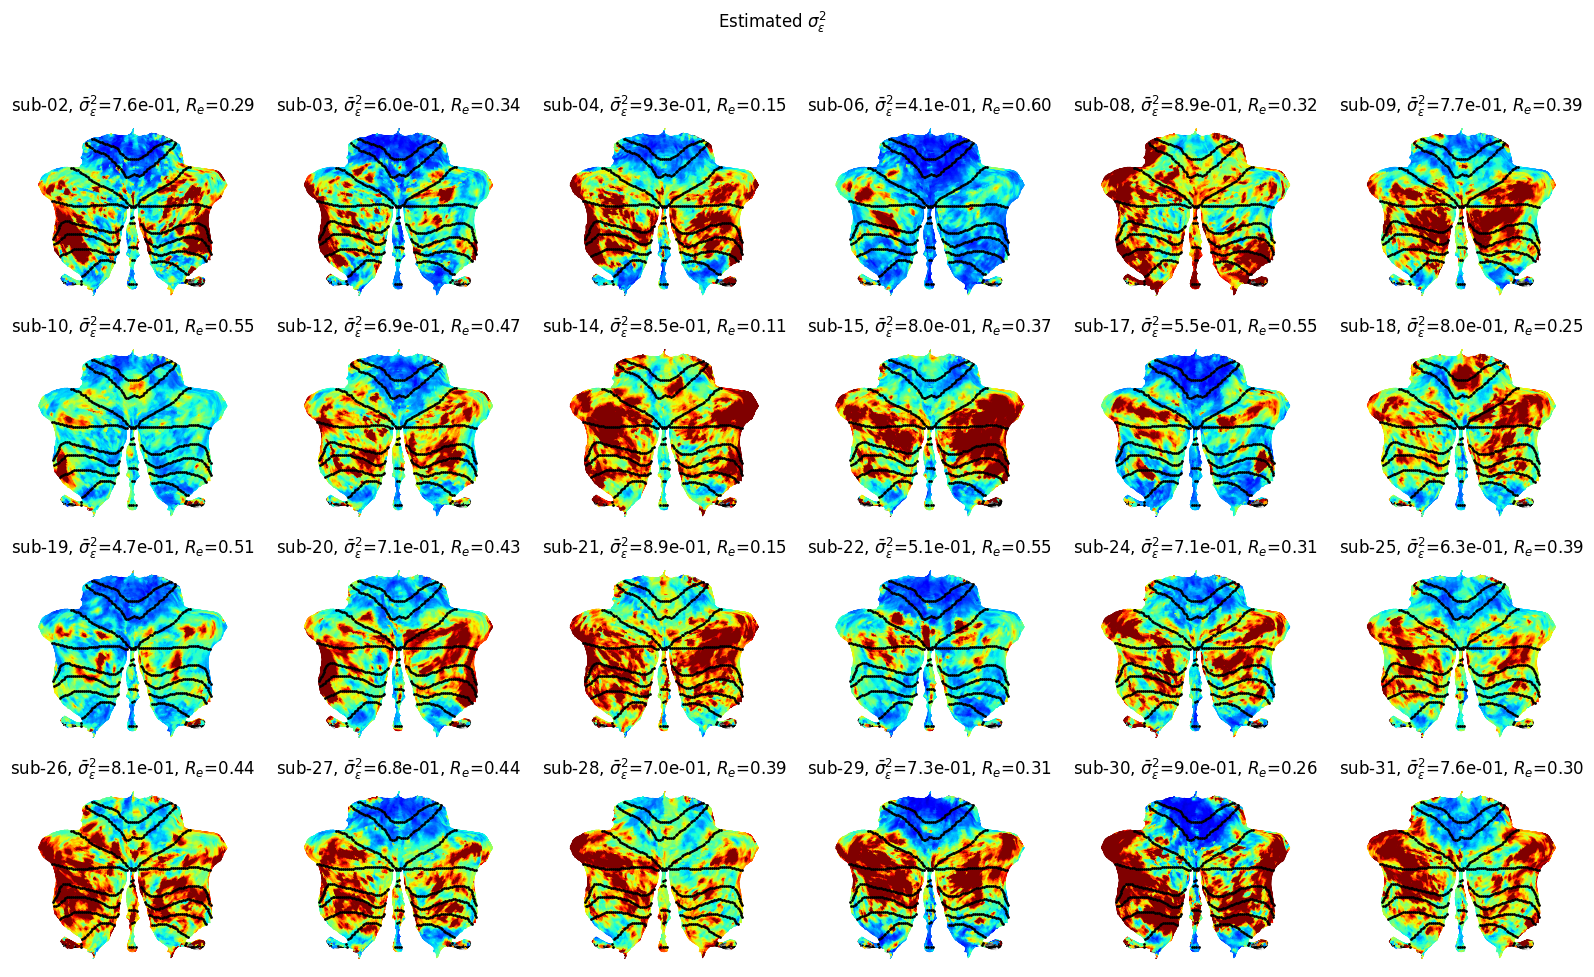

In [9]:
cereb_atlas,_ = at.get_atlas('SUIT3')
plt.figure(figsize=(20,11))
plt.suptitle('Estimated $\sigma^2_\epsilon$')
for i, sub in enumerate(subject_list):
    plt.subplot(4,6,i+1)
    plot_cereb_data(sigma2_mat[i],cereb_atlas,cscale=[0,1])
    sub_perf = df_same['R_eval'].iloc[i]
    plt.title(f'{sub}, $\\bar{{\\sigma}}^2_\\epsilon$={np.nanmean(sigma2_mat[i]):.1e}, $R_e$={sub_perf:.2f}')

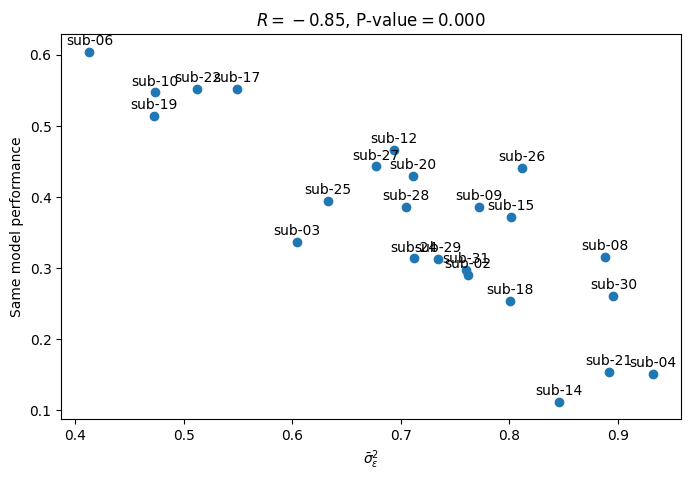

In [25]:
mean_sigma2 = np.nanmean(np.stack(sigma2_mat, axis=0), axis=1)
plt.figure(figsize=(8,5))
plt.scatter(mean_sigma2, df_same['R_eval'])
plt.xlabel('$\\bar{{\\sigma}}^2_\\epsilon$')
plt.ylabel('Same model performance')
R, Pval = stats.pearsonr(mean_sigma2, df_same['R_eval'], alternative='less')
plt.title(f'$R={R:.2f}$, P-value$={Pval:.3f}$')
for i, sub in enumerate(subject_list):
    plt.annotate(f'{sub}', (mean_sigma2[i], df_same['R_eval'].iloc[i]), textcoords="offset points", xytext=(0,5), ha='center')

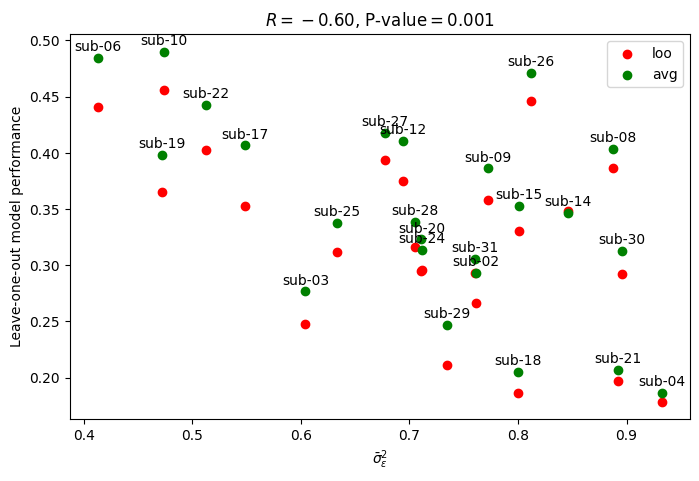

In [17]:
mean_sigma2 = np.nanmean(np.stack(sigma2_mat, axis=0), axis=1)
plt.figure(figsize=(8,5))
plt.scatter(mean_sigma2, df_loo['R_eval'], color='red', label='loo')
plt.scatter(mean_sigma2, df_avg['R_eval'], color='green', label='avg')
plt.xlabel('$\\bar{{\\sigma}}^2_\\epsilon$')
plt.ylabel('Leave-one-out model performance')
R, Pval = stats.pearsonr(mean_sigma2, df_avg['R_eval'], alternative='less')
plt.title(f'$R={R:.2f}$, P-value$={Pval:.3f}$')
plt.legend()
for i, sub in enumerate(subject_list):
    plt.annotate(f'{sub}', (mean_sigma2[i], df_avg['R_eval'].iloc[i]), textcoords="offset points", xytext=(0,5), ha='center')

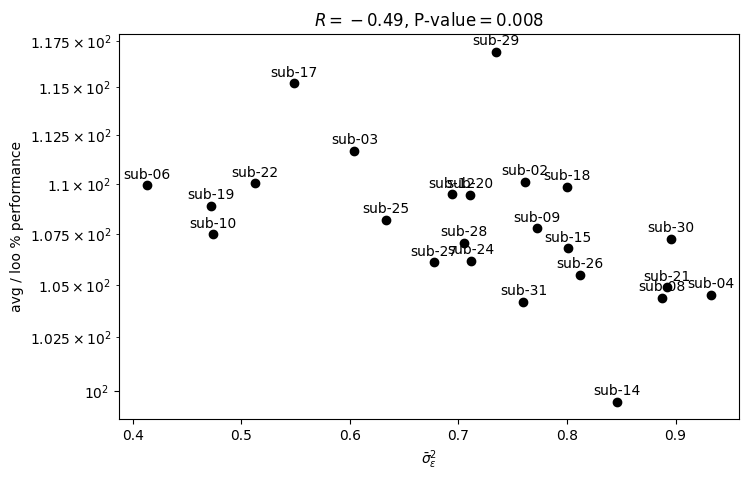

In [22]:
mean_sigma2 = np.nanmean(np.stack(sigma2_mat, axis=0), axis=1)
proportion = df_avg['R_eval']/df_loo['R_eval']*100
plt.figure(figsize=(8,5))
plt.scatter(mean_sigma2, proportion, color='black')
plt.xlabel('$\\bar{{\\sigma}}^2_\\epsilon$')
plt.ylabel('avg / loo % performance')
plt.yscale('log')
R, Pval = stats.pearsonr(mean_sigma2, proportion, alternative='less')
plt.title(f'$R={R:.2f}$, P-value$={Pval:.3f}$')
for i, sub in enumerate(subject_list):
    plt.annotate(f'{sub}', (mean_sigma2[i], proportion.iloc[i]), textcoords="offset points", xytext=(0,5), ha='center')

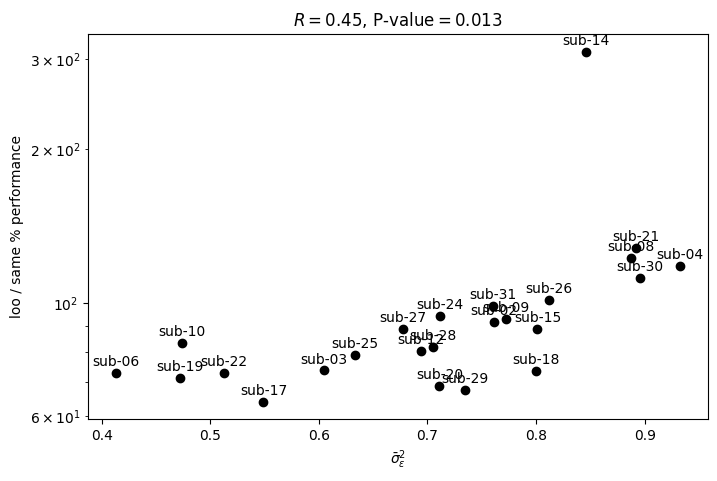

In [23]:
mean_sigma2 = np.nanmean(np.stack(sigma2_mat, axis=0), axis=1)
proportion = df_loo['R_eval']/df_same['R_eval']*100
plt.figure(figsize=(8,5))
plt.scatter(mean_sigma2, proportion, color='black')
plt.xlabel('$\\bar{{\\sigma}}^2_\\epsilon$')
plt.ylabel('loo / same % performance')
plt.yscale('log')
R, Pval = stats.pearsonr(mean_sigma2, proportion, alternative='greater')
plt.title(f'$R={R:.2f}$, P-value$={Pval:.3f}$')
for i, sub in enumerate(subject_list):
    plt.annotate(f'{sub}', (mean_sigma2[i], proportion.iloc[i]), textcoords="offset points", xytext=(0,5), ha='center')

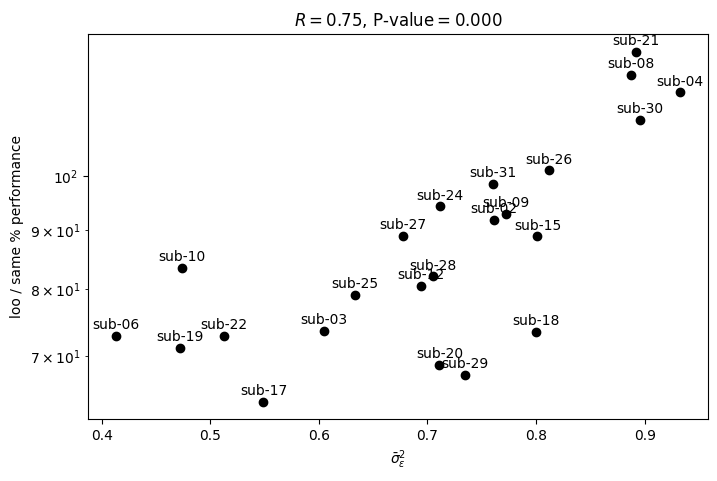

In [24]:
mean_sigma2 = np.nanmean(np.stack(sigma2_mat, axis=0), axis=1)
mean_sigma2 = np.delete(mean_sigma2, 8, axis=0)
proportion = df_loo['R_eval']/df_same['R_eval']*100
proportion = np.delete(proportion, 8)
plt.figure(figsize=(8,5))
plt.scatter(mean_sigma2, proportion, color='black')
plt.xlabel('$\\bar{{\\sigma}}^2_\\epsilon$')
plt.ylabel('loo / same % performance')
plt.yscale('log')
R, Pval = stats.pearsonr(mean_sigma2, proportion, alternative='greater')
plt.title(f'$R={R:.2f}$, P-value$={Pval:.3f}$')
new_subject_list = subject_list.copy()
new_subject_list.pop(8)
for i, sub in enumerate(new_subject_list):
    plt.annotate(f'{sub}', (mean_sigma2[i], proportion[i]), textcoords="offset points", xytext=(0,5), ha='center')